In [1]:
# auto update python files
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
# import libraries
import sys
sys.path.append('../tracking_validation/')

In [12]:
import numpy as np
from utils import *
from association_gate import association_gate
#from temp_csv_parser import *


In [4]:
# load association params
from load_association_params import AssociationParams
params = AssociationParams("/home/yoshiri/autoware/src/universe/autoware.universe/perception/multi_object_tracker/config/data_association_matrix.param.yaml")
params.getAssociationParams("CAR", "CAR")

[2.0, 3.6, 12.1, 1.047, 0.1]

In [13]:
# rosbag 
rosbag_file = "/home/yoshiri/autoware_bag/SPkadai/117/scenario_0_0.db3"
topic_list = ["/perception/object_recognition/detection/objects","/perception/object_recognition/tracking/objects"]

# get topics dict
#topics_dict = get_topics_dict(rosbag_file, topic_list)

[INFO 1682931345.657991051] [rosbag2_storage]: Opened database '/home/yoshiri/autoware_bag/SPkadai/117/scenario_0_0.db3' for READ_ONLY. (open() at ./src/rosbag2_storage_default_plugins/sqlite/sqlite_storage.cpp:204)


In [118]:
from autoware_auto_perception_msgs.msg import DetectedObject
from autoware_auto_perception_msgs.msg import TrackedObject
from autoware_auto_perception_msgs.msg import DetectedObjectKinematics
from autoware_auto_perception_msgs.msg import ObjectClassification
from autoware_auto_perception_msgs.msg import Shape

In [30]:
from tracking_parser import TrackingParser
tp = TrackingParser(rosbag_file)

[INFO 1682933487.830180569] [rosbag2_storage]: Opened database '/home/yoshiri/autoware_bag/SPkadai/117/scenario_0_0.db3' for READ_ONLY. (open() at ./src/rosbag2_storage_default_plugins/sqlite/sqlite_storage.cpp:204)


(<Figure size 1600x1500 with 6 Axes>,
 array([<AxesSubplot:title={'center':'x'}, xlabel='time [s]'>,
        <AxesSubplot:title={'center':'y'}, xlabel='time [s]'>,
        <AxesSubplot:title={'center':'yaw'}, xlabel='time [s]'>,
        <AxesSubplot:title={'center':'vx'}, xlabel='time [s]'>,
        <AxesSubplot:title={'center':'covariance_x'}, xlabel='time [s]'>,
        <AxesSubplot:title={'center':'covariance_y'}, xlabel='time [s]'>],
       dtype=object))

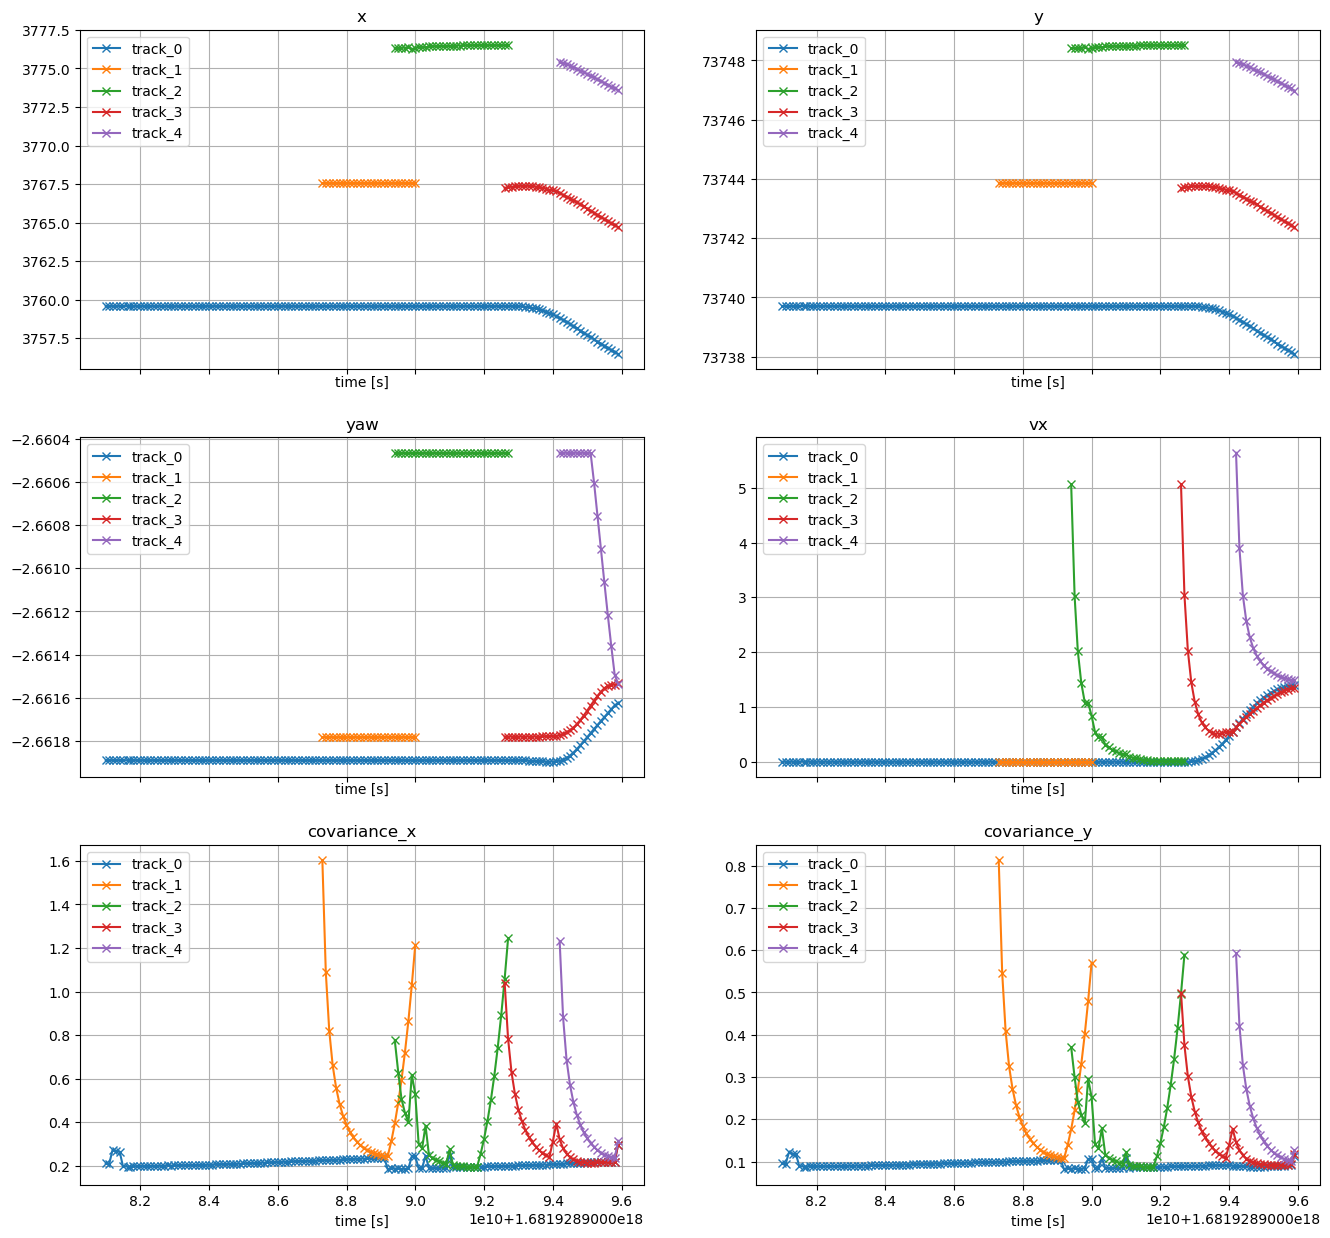

In [31]:
tp.plot_data()

In [142]:
import uuid
def getUUID(obj):
    return str(uuid.UUID(bytes=obj.object_id.uuid.tobytes()))

getUUID(topics_dict["/perception/object_recognition/tracking/objects"][0][1].objects[0])

unique_identifier_msgs.msg.UUID(uuid=array([186, 151, 129,  42, 210, 104, 149, 229, 156, 155, 227, 223, 200,
        87, 152,  82], dtype=uint8))


'ba97812a-d268-95e5-9c9b-e3dfc8579852'

In [158]:
import uuid
# check id

def getTrackingTopics(topics_dict):
    topics = {}
    # get topics
    for stamp, msg in topics_dict["/perception/object_recognition/tracking/objects"]:
        time = stamp
        for tracked_obj in msg.objects:
            id = getUUID(tracked_obj)
            if id not in topics.keys():
                topics[id] = []
            topics[id].append([time, tracked_obj])
    return topics

tracked_obj_topics = getTrackingTopics(topics_dict)


In [157]:
tracked_obj_topics.keys()
topics_dict["/perception/object_recognition/tracking/objects"]

[[1681928980997827656,
  autoware_auto_perception_msgs.msg.TrackedObjects(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1681928980, nanosec=987476009), frame_id='map'), objects=[autoware_auto_perception_msgs.msg.TrackedObject(object_id=unique_identifier_msgs.msg.UUID(uuid=array([186, 151, 129,  42, 210, 104, 149, 229, 156, 155, 227, 223, 200,
          87, 152,  82], dtype=uint8)), existence_probability=0.0, classification=[autoware_auto_perception_msgs.msg.ObjectClassification(label=1, probability=1.0)], kinematics=autoware_auto_perception_msgs.msg.TrackedObjectKinematics(pose_with_covariance=geometry_msgs.msg.PoseWithCovariance(pose=geometry_msgs.msg.Pose(position=geometry_msgs.msg.Point(x=3759.5928970352898, y=73739.71130046145, z=20.556364059448242), orientation=geometry_msgs.msg.Quaternion(x=0.0, y=0.0, z=-0.9713731197630094, w=0.2375589657366735)), covariance=array([0.2097757 , 0.09576888, 0.        , 0.        , 0.        ,
         0.        , 0.09576888, 0.0

In [189]:
def get_topic_list(tlist):
    data = []
    for time, topic in tlist:
        xy = get2DPosition(topic)
        yaw = getYaw(topic)
        vx = getVX(topic)
        length = topic.shape.dimensions.x
        width = topic.shape.dimensions.y
        data.append([time, xy[0], xy[1], yaw, vx,length, width])
    
    data = np.array(data).reshape(-1,7)
    return data

def get_topic_data(tlist):
    data = {}
    keys = ["time", "x", "y", "yaw", "vx", "length", "width", "covariance"]
    for key in keys:
        data[key] = []

    for time, topic in tlist:
        xy = get2DPosition(topic)
        data["time"].append(time)
        data["x"].append(xy[0])
        data["y"].append(xy[1])
        data["yaw"].append(getYaw(topic))
        data["vx"].append(getVX(topic))
        data["length"].append(topic.shape.dimensions.x)
        data["width"].append(topic.shape.dimensions.y)
        data["covariance"].append(get2DPositionCovariance(topic))    
    
    data["covariance"] = np.array(data["covariance"]).reshape(-1,4)
    return data


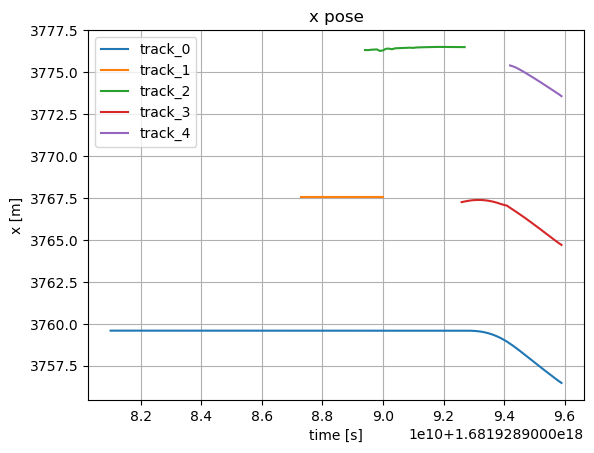

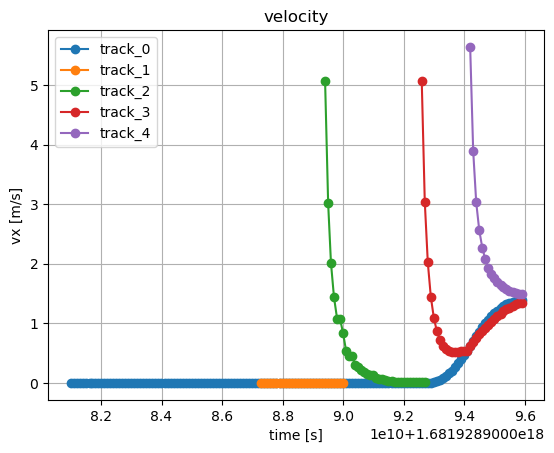

In [192]:
for key in tracked_obj_topics.keys():
    tl = get_topic_list(tracked_obj_topics[key])
    plt.plot(tl[:,0], tl[:,1])

plt.title("x pose")
plt.legend(["track_" + str(i) for i in range(len(tracked_obj_topics.keys()))])
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("x [m]")

plt.figure()

for key in tracked_obj_topics.keys():
    tl = get_topic_list(tracked_obj_topics[key])
    plt.plot(tl[:,0], tl[:,4], marker="o")

plt.title("velocity")
plt.xlabel("time [s]")
plt.ylabel("vx [m/s]")
plt.legend(["track_" + str(i) for i in range(len(tracked_obj_topics.keys()))])
plt.grid()

Text(0, 0.5, 'x [m]')

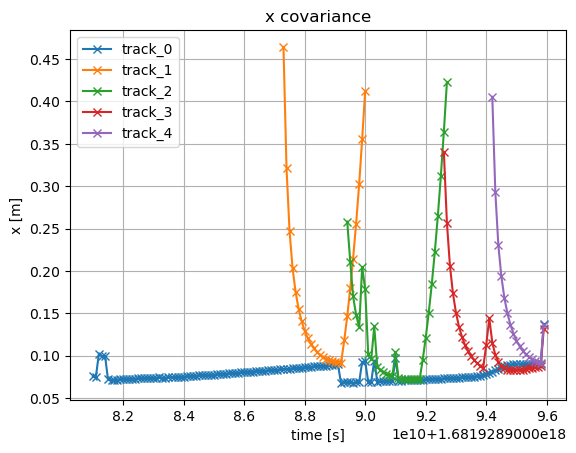

In [194]:
for key in tracked_obj_topics.keys():
    td = get_topic_data(tracked_obj_topics[key])
    plt.plot(td["time"], td["covariance"][:,-1], marker="x")
    
plt.title("x covariance")
plt.legend(["track_" + str(i) for i in range(len(tracked_obj_topics.keys()))])
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("x [m]")

In [200]:
from tracking_parser import TrackingParser

tp = TrackingParser(rosbag_file)
tp.plot_data()

ImportError: attempted relative import with no known parent package

In [204]:
from rosbag_parser import get_topics_as_dict

ImportError: cannot import name 'get_topics_as_dict' from 'rosbag_parser' (/home/yoshiri/extension_ws/src/tracking_validation/notebook/../../lanelet_loader/lanelet_loader/rosbag_parser.py)

<AxesSubplot:xlabel='/perception/object_recognition/tracking/objects/header/stamp'>

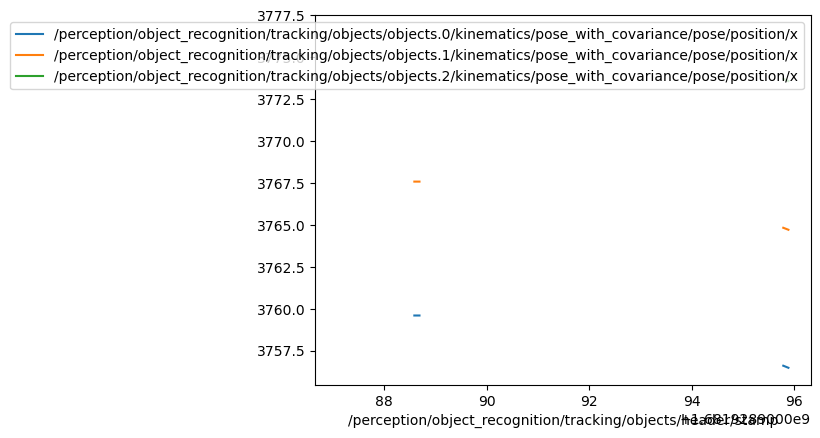

In [109]:
# plot x position of trackers
csv_data.plot(x = stamp_msgs[1],
              y=["/perception/object_recognition/tracking/objects/objects.0/kinematics/pose_with_covariance/pose/position/x",
                 "/perception/object_recognition/tracking/objects/objects.1/kinematics/pose_with_covariance/pose/position/x",
                 "/perception/object_recognition/tracking/objects/objects.2/kinematics/pose_with_covariance/pose/position/x"])

<AxesSubplot:xlabel='/perception/object_recognition/detection/objects/header/stamp'>

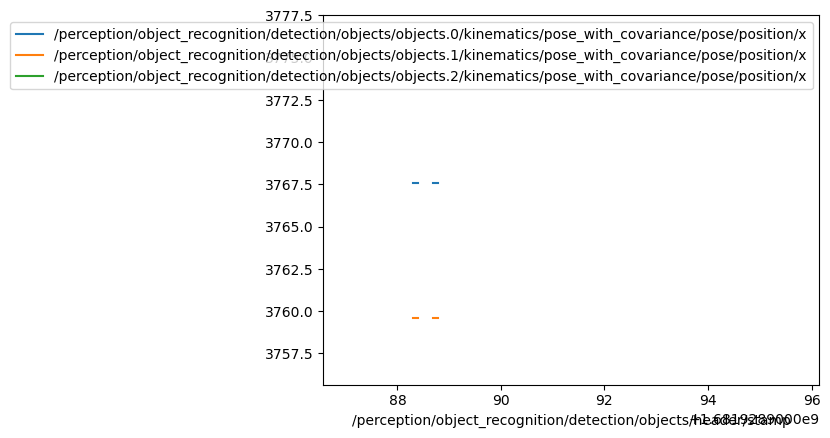

In [114]:
# plot x position of trackers
csv_data.plot(x = stamp_msgs[0],
              y=["/perception/object_recognition/detection/objects/objects.0/kinematics/pose_with_covariance/pose/position/x",
                 "/perception/object_recognition/detection/objects/objects.1/kinematics/pose_with_covariance/pose/position/x",
                 "/perception/object_recognition/detection/objects/objects.2/kinematics/pose_with_covariance/pose/position/x"])

In [92]:
from iou_utils import get_2d_iou

get_2d_iou(test_detected_object, test_detected_object)

AttributeError: module 'tf2_ros' has no attribute 'transformations'